## This notebook contains several feature extraction techniques which are used to extract features from the facial images and then passed to a CNN model to compare their results

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras import regularizers

In [2]:
np.random.seed(42)

# loading data

In [3]:
os.listdir('/kaggle/input/ckplus')

['ck', 'CK+48']

In [4]:
DATADIR = r'/kaggle/input/ckplus/CK+48'

In [5]:
CATEGORIES = os.listdir(DATADIR)
CATEGORIES

['surprise', 'fear', 'sadness', 'disgust', 'contempt', 'happy', 'anger']

In [6]:
def load_data():
    DATADIR = r'/kaggle/input/ckplus/CK+48'
    data = []
    # loading training data
    for category in CATEGORIES:
        # create path to image of respective expression
        path = os.path.join(DATADIR, category)
        # get the classification  for each expression 
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            img_array = cv2.imread(os.path.join(path, img), 0)
            data.append([img_array, class_num])
            
    return data

In [7]:
data = load_data()

100%|██████████| 135/135 [00:00<00:00, 245.99it/s]


In [8]:
len(data)

981

# Lets Visualize some images 

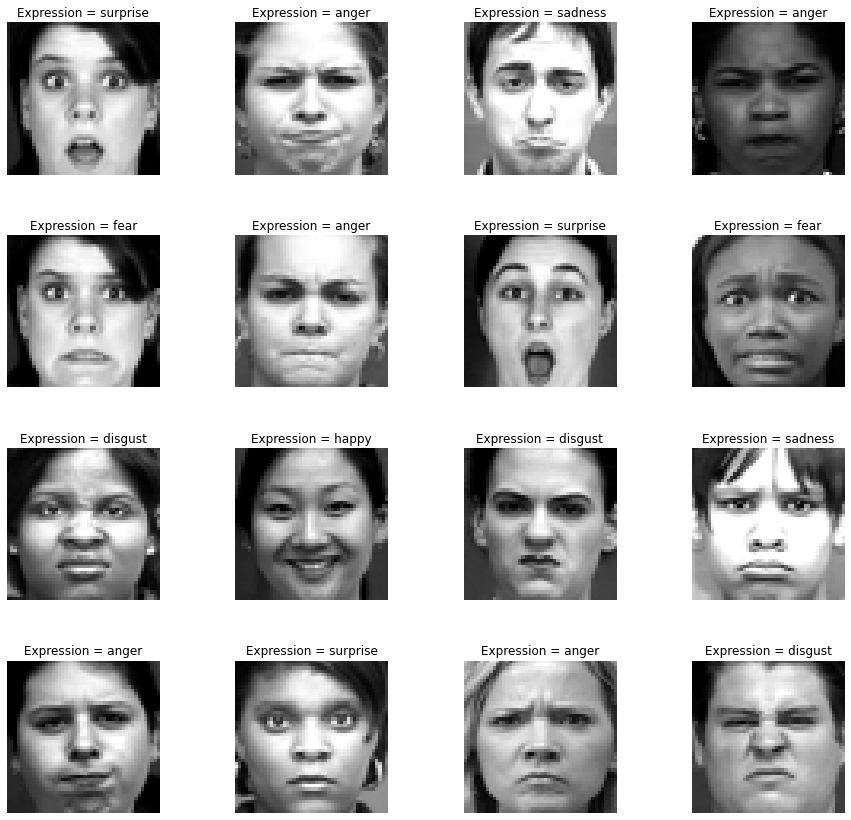

In [9]:
L = 4
W = 4
fig, axes = plt.subplots(L, W, figsize = (15,15))
axes = axes.ravel()

for i in range(0, L * W):  
    sample = random.choice(data)
    axes[i].set_title("Expression = "+str(CATEGORIES[sample[1]]))
    axes[i].imshow(sample[0], cmap='gray')
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)

# Creating training and testing data

In [10]:
X = np.array([ x[0] for x in data])
y = np.array([Y[1] for Y in data])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

In [12]:
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("-------------------------------")
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (784, 48, 48)
y_train shape:  (784,)
-------------------------------
X_test shape:  (197, 48, 48)
y_test shape:  (197,)


In [13]:
# reshaping y_train and y_test
y_train = np.reshape(y_train, (len(y_train),1))
y_test  = np.reshape(y_test , (len(y_test ),1))

print("After reshaping")
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

After reshaping
y_train shape:  (784, 1)
y_test shape:  (197, 1)


In [14]:
X_train_Gabor  = X_train
X_test_Gabor = X_test

## Adding color channel 

In [15]:
X_train = np.expand_dims(X_train, axis=3)
X_test = np.expand_dims(X_test, axis=3)

print("After adding color channel")
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

After adding color channel
X_train shape:  (784, 48, 48, 1)
X_test shape:  (197, 48, 48, 1)


## Normalizing pixel values 

In [16]:
X_train = X_train / 255.0
X_test = X_test / 255.0

## Converting single values to category array 

In [17]:
y_train[0]

array([6])

In [18]:
y_train_SVM = y_train
y_test_SVM = y_test

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [19]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [20]:
y_train.shape, y_test.shape

((784, 7), (197, 7))

# Feature Extraction

# [HOG technqiue](https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/) 
For more info on implementation [visit here](https://www.analyticsvidhya.com/blog/2019/09/feature-engineering-images-introduction-hog-feature-descriptor/)

In [21]:
from skimage.transform import resize
from skimage.feature import hog

### How Hog looks ?

(-0.5, 47.5, 47.5, -0.5)

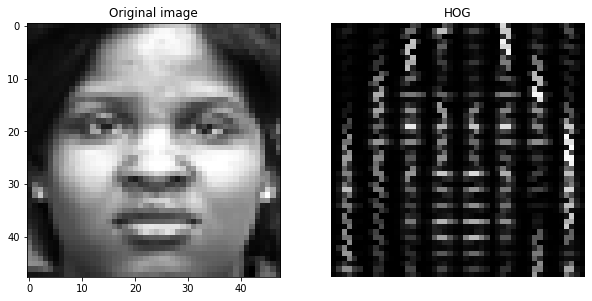

In [22]:
plt.figure(figsize=(10, 10))


plt.subplot(1,2,1)
img = random.choice(X_train)
# first image needs to be resized before passing it to HOG descriptor
resized_img =  resize(img, (128, 64))
plt.title("Original image")
plt.imshow(img, cmap='gray')
fd, hog_image = hog(
    resized_img, 
    orientations=9, 
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2), 
    visualize=True, 
    multichannel=True
)
plt.subplot(1,2,2)
plt.title("HOG")
plt.imshow(resize(hog_image, (48, 48)), cmap='gray')
plt.axis('off')

### Creating Feature Vectors for training and testing 

In [23]:
def Create_Hog_features(data):
    Feature_data = np.zeros((len(data),48,48))

    for i in range(len(data)):
        img = data[i]
        resized_img = resize(img, (128, 64))
        fd, hog_image = hog(
            resized_img, 
            orientations=9, 
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2), 
            visualize=True, 
            multichannel=True
        )
        Feature_data[i] = resize(hog_image, (48, 48))
    return Feature_data

In [24]:
Feature_X_train = Create_Hog_features(X_train)
Feature_X_train.shape

(784, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

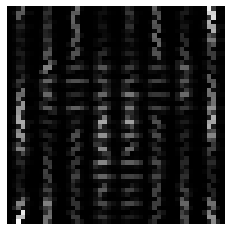

In [25]:
plt.imshow(random.choice(Feature_X_train), cmap='gray')
plt.axis('off')

In [26]:
# doing same for test data 
Feature_X_test = Create_Hog_features(X_test)

Feature_X_test.shape

(197, 48, 48)

(-0.5, 47.5, 47.5, -0.5)

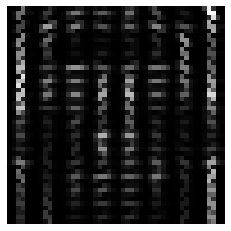

In [27]:
plt.imshow(random.choice(Feature_X_test), cmap='gray')
plt.axis('off')

In [28]:
# Again adding color channel as it got removed while converting img to hog img
X_train_HOG = np.expand_dims(Feature_X_train, axis=3)
X_test_HOG = np.expand_dims(Feature_X_test, axis=3)

print("After adding color channel")
print("X_train_HOG shape: ", X_train_HOG.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)

After adding color channel
X_train_HOG shape:  (784, 48, 48, 1)
X_test_HOG shape:  (197, 48, 48, 1)


In [29]:
print("X_train_HOG shape: ", X_train_HOG.shape)
print("y_train shape: ", y_train.shape)
print("X_test_HOG shape: ", X_test_HOG.shape)
print("y_test shape: ", y_test.shape)

X_train_HOG shape:  (784, 48, 48, 1)
y_train shape:  (784, 7)
X_test_HOG shape:  (197, 48, 48, 1)
y_test shape:  (197, 7)


### Data Augmentation

In [30]:
# train_datagen = ImageDataGenerator(
#     rotation_range=25, width_shift_range=0.1,
#     height_shift_range=0.1, shear_range=0.2, 
#     zoom_range=0.2,horizontal_flip=True, 
#     fill_mode="nearest"
# )

### Training and testing the HOG - CNN model

Referred from [here](https://www.kaggle.com/milan400/human-emotion-detection-by-using-cnn#Creating-Model)

In [31]:
def create_model(input_shape=None):
    if input_shape is None :
        input_shape=(48,48,1)

    model = Sequential()
    model.add(Conv2D(6, (5, 5), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))
    
    return model 

In [32]:
es = EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=10, verbose=2,
    mode='max', baseline=None, restore_best_weights=True
)
lr = ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=5, verbose=2,
    mode='max', min_delta=1e-5, cooldown=0, min_lr=0
)

callbacks = [es, lr]

In [33]:
HOG_model = create_model()

In [34]:
HOG_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

In [35]:
HOG_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam' )

In [36]:
HOG_history = HOG_model.fit(X_train_HOG, y_train, batch_size=8 , epochs=50, validation_data = (X_test_HOG, y_test), callbacks = [callbacks])

Epoch 1/50
98/98 [==============================] - 6s 9ms/step - loss: 1.8770 - accuracy: 0.2445 - val_loss: 1.8586 - val_accuracy: 0.2132
Epoch 2/50
98/98 [==============================] - 0s 3ms/step - loss: 1.7954 - accuracy: 0.2837 - val_loss: 1.7057 - val_accuracy: 0.3401
Epoch 3/50
98/98 [==============================] - 0s 3ms/step - loss: 1.5566 - accuracy: 0.4349 - val_loss: 1.3422 - val_accuracy: 0.5025
Epoch 4/50
98/98 [==============================] - 0s 3ms/step - loss: 1.2259 - accuracy: 0.5448 - val_loss: 1.1046 - val_accuracy: 0.5888
Epoch 5/50
98/98 [==============================] - 0s 3ms/step - loss: 0.9711 - accuracy: 0.6605 - val_loss: 0.9578 - val_accuracy: 0.6396
Epoch 6/50
98/98 [==============================] - 0s 4ms/step - loss: 0.8531 - accuracy: 0.6960 - val_loss: 0.8765 - val_accuracy: 0.6701
Epoch 7/50
98/98 [==============================] - 0s 4ms/step - loss: 0.7677 - accuracy: 0.7213 - val_loss: 0.7526 - val_accuracy: 0.6954
Epoch 8/50
98/98 [==

In [37]:
def plot_performance(history):
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val loss evolution')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')

    plt.legend()
    plt.grid()
    plt.title('train and val accuracy')

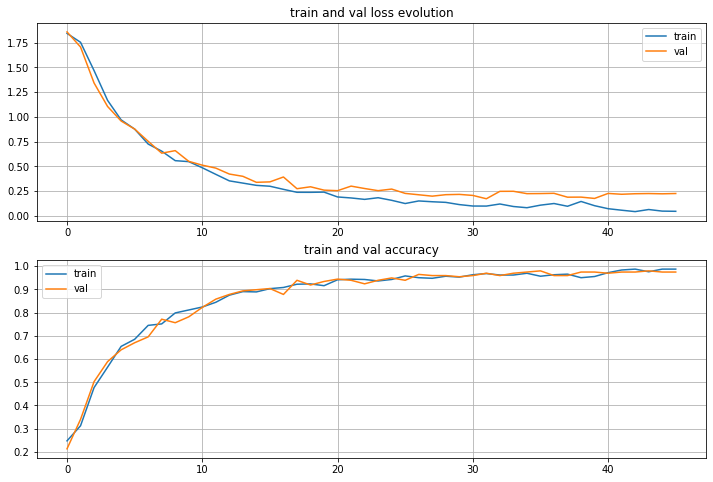

In [38]:
plot_performance(HOG_history)

In [39]:
acc = []

In [40]:
HOG_acc = HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1]
acc.append(HOG_acc)
print("HOG Accuracy :",HOG_model.evaluate(X_test_HOG, y_test, verbose = 0)[1])

HOG Accuracy : 0.9796954393386841


In [44]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = HOG_model.predict(X_test_HOG)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


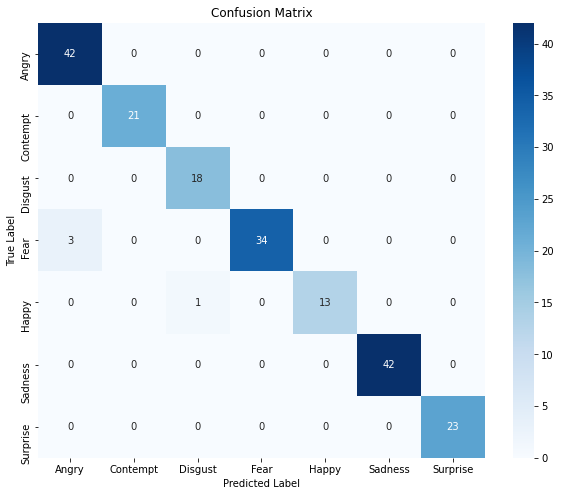

In [46]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
CLASS_LABELS = ['Angry', 'Contempt', 'Disgust', 'Fear', 'Happy', 'Sadness', 'Surprise']

# Predict class indices
y_pred = HOG_model.predict(X_test_HOG)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Confusion matrix
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="Blues", xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [49]:
# Print classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=CLASS_LABELS)
print(report)

# You can also print specific metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
from sklearn.metrics import f1_score
f1_macro = f1_score(y_true_classes, y_pred_classes, average='macro')
print(f"F1 Score (Macro): {f1_macro:.4f}")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")


              precision    recall  f1-score   support

       Angry       0.93      1.00      0.97        42
    Contempt       1.00      1.00      1.00        21
     Disgust       0.95      1.00      0.97        18
        Fear       1.00      0.92      0.96        37
       Happy       1.00      0.93      0.96        14
     Sadness       1.00      1.00      1.00        42
    Surprise       1.00      1.00      1.00        23

    accuracy                           0.98       197
   macro avg       0.98      0.98      0.98       197
weighted avg       0.98      0.98      0.98       197

F1 Score (Macro): 0.9799
Accuracy:  0.9797
Precision: 0.9830
Recall:    0.9782


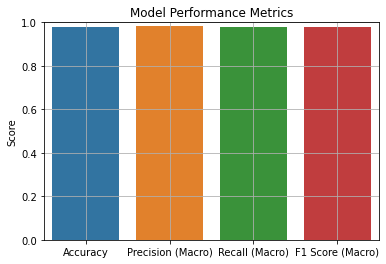

In [50]:
from sklearn.metrics import precision_score, recall_score, accuracy_score


metrics = {
    "Accuracy": accuracy_score(y_true_classes, y_pred_classes),
    "Precision (Macro)": precision_score(y_true_classes, y_pred_classes, average='macro'),
    "Recall (Macro)": recall_score(y_true_classes, y_pred_classes, average='macro'),
    "F1 Score (Macro)": f1_score(y_true_classes, y_pred_classes, average='macro')
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
plt.ylim(0, 1)
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.grid(True)
plt.show()
